# Action Grammars: A Grammar-Induction Based Method for Learning Temporally-Extended Actions
## Authors: Robert Lange and Aldo Faisal | January 2019

In [1]:
!pip install -r requirements.txt --quiet

Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/b9/9jvh8qqs56j5p1rqk4msfsbh0000gn/T/pip-install-ed0p9sb6/functools32/


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import numpy as np

import gym
import gym_hanoi

In [3]:
from agents import Agent_Q, SMDP_Agent_Q, Macro, SMDPQTable
from utils.q_learning import  q_learning
from utils.smdp_q_learning import smdp_q_learning

from utils.learning_params import *
from utils.general import *
from utils.plotting import *

In [4]:
# Create directory - Learning performance
results_dir = os.getcwd() + "/results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print("Created New Results Directory")

# Create directory - Log directory
log_dir = os.getcwd() + "/logs/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
    
# Create directory - Figure directory
fig_dir = os.getcwd() + "/figures/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Fig Directory")

# Towers of Hanoi - Setup

In [5]:
print(learning_parameters("Q-Learning"))

{'alpha': 0.8, 'gamma': 0.95, 'lambd': 0.1, 'epsilon': 0.1}


In [6]:
learning_setup = {4: {"num_episodes": 100,
                      "max_steps": 500},
                  5: {"num_episodes": 1000,
                      "max_steps": 1000},
                  6: {"num_episodes": 5000,
                      "max_steps": 2000},
                  7: {"num_episodes": 10000,
                      "max_steps": 4000},
                  8: {"num_episodes": 20000,
                      "max_steps": 8000}}

### Simple TD($\lambda$) Learning

In [12]:
log_episodes = 10
log_freq = 20
num_episodes = learning_setup[5]["num_episodes"]
max_steps = learning_setup[5]["max_steps"]

In [13]:
def run_learning(num_times, num_disks, num_episodes, max_steps,
                 log_episodes, log_freq, save_fname=None):
    its, steps, sd_steps, rew, sd_rew = [], [], [], [], []
    
    for i in range(num_times):
        tic = time.time()
        env = gym.make("Hanoi-v0")
        env.set_env_parameters(num_disks, env_noise=0, verbose=False)
        
        agent = Agent_Q(env)
        params = learning_parameters(l_type="Q-Learning")
        hist, er_buffer = q_learning(env, agent, num_episodes, max_steps,
                                     **params,
                                     log_freq=log_freq,
                                     log_episodes=log_episodes, verbose=False)

        # Process results and append
        its_t, steps_t, sd_steps_t, rew_t, sd_rew_t =  hist[:, 0], hist[:, 1], hist[:,2], hist[:, 3], hist[:, 4]
        its.append(its_t)
        steps.append(steps_t)
        sd_steps.append(sd_steps_t)
        rew.append(rew_t)
        sd_rew.append(sd_rew_t)
        t_total = time.time() - tic
        print("Learning Run {} Done - Time: {}".format(i+1, round(t_total, 2)))
    
    its = np.array(its).mean(axis=0)
    steps = np.array(steps).mean(axis=0)
    sd_steps = np.array(sd_steps).mean(axis=0)
    rew = np.array(rew).mean(axis=0)
    sd_rew = np.array(sd_rew).mean(axis=0)
    
    if save_fname is not None:
        out = np.array([its, steps, sd_steps, rew, sd_rew])
        np.savetxt(save_fname, out)
    return env, agent, its, steps, sd_steps, rew, sd_rew

In [14]:
env, agent, its, steps, sd_steps, rew, sd_rew = run_learning(5, 5, num_episodes, max_steps,
                                                             log_episodes, log_freq)

Learning Run 1 Done - Time: 17.96
Learning Run 2 Done - Time: 17.38
Learning Run 3 Done - Time: 22.99
Learning Run 4 Done - Time: 19.36
Learning Run 5 Done - Time: 26.2


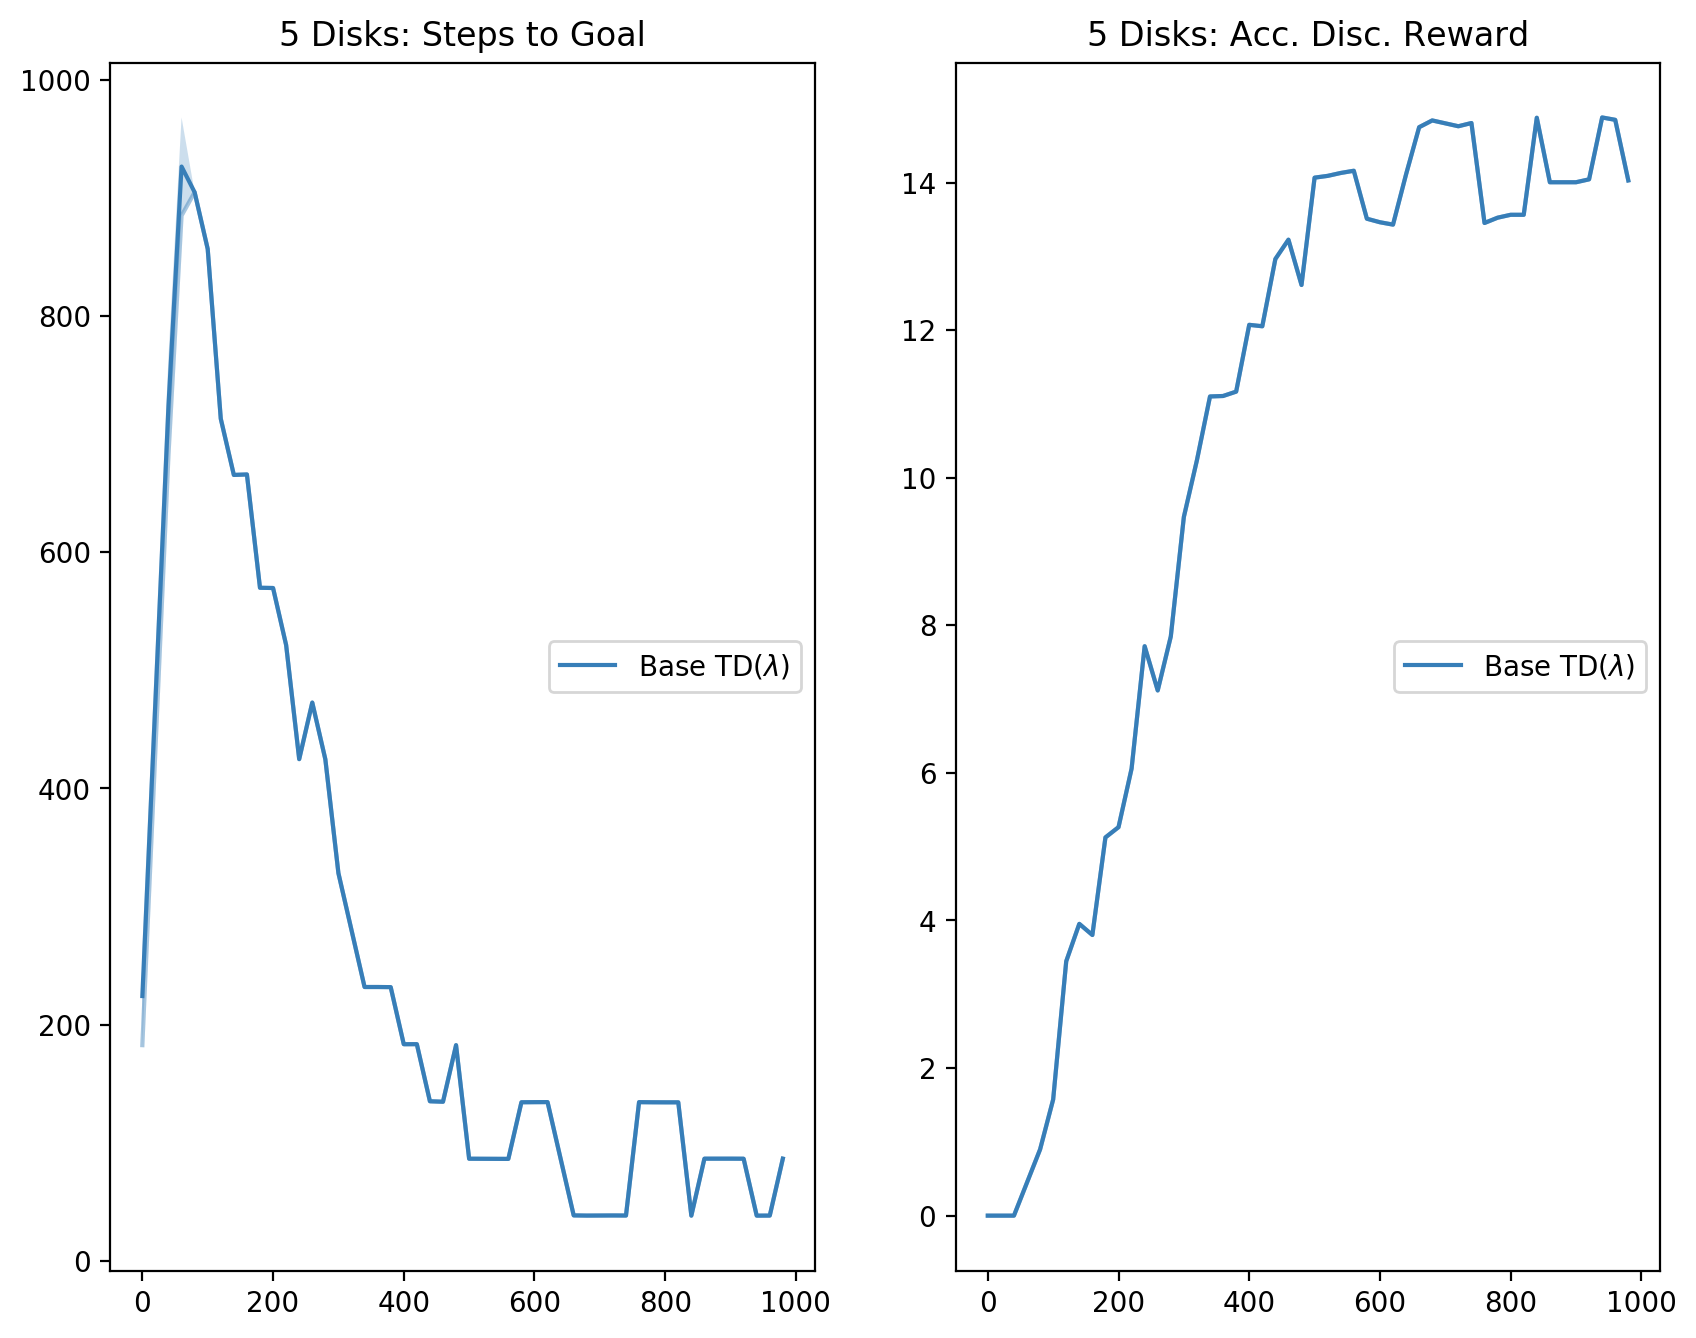

In [25]:
plot_all_learning([its], [steps], [sd_steps], [rew], [sd_rew], smooth_degree=4,
                  sub_titles=[r"5 Disks: Steps to Goal",
                              r"5 Disks: Acc. Disc. Reward"],
                  labels=[r"Base TD($\lambda$)"])

In [21]:
get_rollout_policy(env, agent, max_steps, grammar=False)

NameError: name 'env' is not defined

In [ ]:
rollout_sentence = get_rollout_policy(env, agent, max_steps, grammar=True)

### Check Context-Free Grammar Inference

### SMDP-Q-Learning

In [22]:
seq_macros = {4: ["abd"],
              5: ["bafbcd", "baf", "ec", "bc"],
              6: ["abdaef", "abdced", "abdaef", "aedce",
                  "abdce", "abd", "ae", "ce"], 
              7: ["bafbcdbafecfbafbcdbcfecd", "bafbcdbafecf",
                  "bafecdbcfecbafbcdbcfec", "bafbcdbafec",
                  "bcfecbafbcec"]}

In [62]:
N = 5
env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0, verbose=False)

macros = []
for i in range(len(seq_macros[N])):
    macros.append(Macro(env, seq_macros[N][i]))

In [63]:
agent = SMDP_Agent_Q(env, macros)
params = learning_parameters(l_type="SMDP-Q-Learning")
hist, er_buffer = smdp_q_learning(env, agent, num_episodes, max_steps,
                                  **params,
                                  log_freq=log_freq,
                                  log_episodes=log_episodes, verbose=True)

1 [1, 0, 5]
None [1, 0, 5]
4 [4, 2]
None [4, 2]
None [4, 2]
None [4, 2]
4 [4, 2]
2 [4, 2]
1 [1, 2]
None [1, 2]
None [1, 0, 5, 1, 2, 3]
None [1, 0, 5]
None [1, 2]
None [1, 0, 5, 1, 2, 3]
1 [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
1 [1, 0, 5, 1, 2, 3]
0 [1, 0, 5, 1, 2, 3]
5 [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
1 [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
1 [1, 0, 5]
None [1, 0, 5]
4 [4, 2]
2 [4, 2]
1 [1, 2]
2 [1, 2]
4 [4, 2]
2 [4, 2]
1 [1, 0, 5]
0 [1, 0, 5]
5 [1, 0, 5]
None [1, 2]
4 [4, 2]
2 [4, 2]
1 [1, 0, 5]
None [1, 0, 5]
4 [4, 2]
None [4, 2]
1 [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
1 [1, 2]
2 [1, 2]
1 [1, 0, 5]
None [1, 0, 5]
1 [1, 2]
2 [1, 2]
1 [1, 0, 5]
None [1, 0, 5]
4 [4, 2]
None [4, 2]
None [4, 2]
1 [1, 2]
2 [1, 2]
4 [4, 2]
None [4, 2]
1 [1, 0, 5]
None [1, 0, 5]
None [1, 2]
1 [1, 0, 5]
None [1, 0, 5]
1 [1, 0, 5, 1, 2, 3]
None [1, 0, 5, 1, 2, 3]
None [1, 0, 5]
1 [1, 2]
2 [1, 2]
1 [1, 0, 5, 1, 2, 3

KeyError: 7